In [1]:
import warnings
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt

from os.path import join
from IPython import display
from sklearn.datasets import load_digits
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import (silhouette_score, homogeneity_score, completeness_score, v_measure_score) 
from sklearn.cluster import (KMeans, AgglomerativeClustering, DBSCAN)
from sklearn.preprocessing import StandardScaler

In [2]:
DATA_PATH = "../data"
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")
warnings.filterwarnings("ignore")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

### Задание 1. Реализация Kmeans

5 баллов

В данном задании вам предстоит дописать код класса `MyKMeans`. Мы на простом примере увидим, как подбираются центры кластеров и научимся их визуализировать.

Сгенерируем простой набор данных, 400 объектов и 2 признака (чтобы все быстро работало и можно было легко нарисовать):

In [3]:
X, true_labels = make_blobs(400, 2, centers=[[0, 0], [-4, 0], [3.5, 3.5], [3.5, -2.0]])#Generate isotropic Gaussian blobs for clustering.

Напишем функцию `visualize_clusters`, которая по данным и меткам кластеров будет рисовать их и разукрашивать:

In [4]:
def visualize_clusters(X, labels):
    """
    Функция для визуализации кластеров
        :param X: таблица объекты х признаки
        :param labels: np.array[n_samples] - номера кластеров
    """
    
    unique_labels = np.sort(np.unique(labels))
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=labels, 
                    palette="colorblind", legend=False,
                    hue_order=unique_labels)
    plt.xlabel("$X_1$", fontsize=18)
    plt.ylabel("$X_2$", fontsize=18)
    
    for label in labels:
        center = X[(labels == label)].mean(axis=0)
        plt.scatter(center[0], center[1], s=80, c="#201F12", marker=(5, 2))

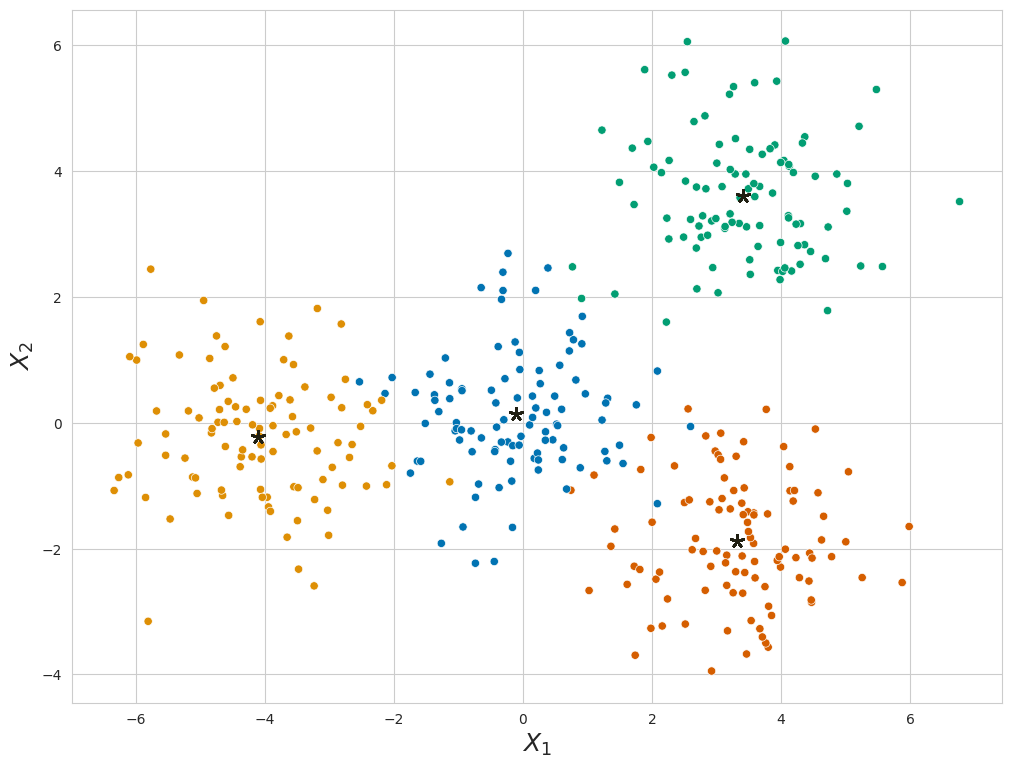

In [5]:
visualize_clusters(X, true_labels)

Напишем свой класс `MyKMeans`, который будет реализовывать алгоритм кластеризации K-средних. Напомним сам алгоритм:

1. Выбираем число кластеров (K)
2. Случайно инициализируем K точек (или выбираем из данных), это будут начальные центры наших кластеров
3. Далее для каждого объекта считаем расстояние до всех кластеров и присваиваем ему метку ближайщего
4. Далее для каждого кластера считаем "центр масс" (среднее значение для каждого признака по всем объектам кластера)
5. Этот "центр масс" становится новым центром кластера
6. Повторяем п.3, 4, 5 заданное число итераций или до сходимости

Во время предсказания алгоритм просто находит ближайщий центроид (центр кластера) для тестового объекта и возвращает его номер.

Реализуйте методы:
* `_calculate_distance(X, centroid)` - вычисляет Евклидово расстояние от всех объектов в `Х` до заданного центра кластера (`centroid`)
* `predict(X)` - для каждого элемента из `X` возвращает номер кластера, к которому относится данный элемент

In [6]:
class MyKMeans:
    def __init__(self, n_clusters, init="random", max_iter=300, visualize=False):
        """
        Конструктор класса MyKMeans
            :param n_clusters: число кластеров
            :param init: способ инициализации центров кластеров
                'random' - генерирует координаты случайно из нормального распределения
                'sample' - выбирает центроиды случайно из объектов выборки
            :param max_iter: заданное число итераций 
                (мы не будем реализовывать другой критерий остановки)
            :param visualize: рисовать ли кластеры и их центроиды в процессе работы
                код будет работать сильно дольше, но красиво...
        """
        
        assert init in ["random", "sample"], f"Неизвестный метод инициализации {init}"
        self.n_clusters = n_clusters
        self.init = init
        self.max_iter = max_iter
        self.centroids = None
        self.visualize = visualize
       
    
    def fit(self, X):
        """
        Подбирает оптимальные центры кластеров
            :param X: наши данные (n_samples, n_features)
        :return self: все как в sklearn
        """
        
        n_samples, n_features = X.shape
        
        # Инициализация центров кластеров
        if self.init == "random":
            centroids = np.random.randn(self.n_clusters, n_features)
        elif self.init == "sample":
            centroids_idx = np.random.choice(np.arange(n_samples), 
                                             size=self.n_clusters, 
                                             replace=False)
            centroids = X[centroids_idx]
        
        # Итеративно двигаем центры
        for _ in range(self.max_iter):
            # Посчитаем расстояния для всех объектов до каждого центроида
            dists = []
            for centroid in centroids:
                dists.append(self._calculate_distance(X, centroid))
            dists = np.concatenate(dists, axis=1)
            # Для каждого объекта найдем, к какому центроиду он ближе
            cluster_labels = np.argmin(dists, axis=1)
            
            # Пересчитаем центр масс для каждого кластера
            centroids = []
            for label in np.sort(np.unique(cluster_labels)):
                center = X[(cluster_labels == label)].mean(axis=0)
                centroids.append(center)
            
            # Отрисуем точки, покрасим по меткам кластера, а также изобразим центроиды
            if self.visualize:
                visualize_clusters(X, cluster_labels)
                display.clear_output(wait=True)
                display.display(plt.gcf())
                plt.close()
                
        self.centroids = np.array(centroids)
        
        return self
    
    
    def predict(self, X):#прото говорит в какой кластер попал новый объект
        """
        Для каждого X возвращает номер кластера, к которому он относится
            :param X: наши данные (n_samples, n_features)
        :return cluster_labels: метки кластеров
        """
        
        """
        YOUR CODE IS HERE
        """
        #нужно опять посчитать расстояния "новых" иксов до вычисленных ранее центроиж 
        dists = []
        for centroid in self.centroids:
            dists.append(self._calculate_distance(X, centroid))
        dists = np.concatenate(dists, axis=1)
        # найти ближайший
        cluster_labels = np.argmin(dists, axis=1)
        
        #cluster_labels = None
            
        return cluster_labels
        
        
    def _calculate_distance(self, X, centroid):
        """
        Вычисляет Евклидово расстояние от всех объектов в Х до заданного центра кластера (centroid)
            :param X: наши данные (n_samples, n_features)
            :param centroid: координаты центра кластера
        :return dist: расстояния от всех X до центра кластера
        """
        
        """
        YOUR CODE IS HERE
        """
        dist = np.linalg.norm((X - centroid), axis=1)
        #dist_2 = np.sqrt(np.sum((X - centroid)**2, axis=1))
        #print('DIST', dist)
        #dist = None
        #print('linalg', dist[0:5])
        #print('sqrt', dist_2[0:5])
        
        return dist.reshape(X.shape[0], 1)
    
    
    def __repr__(self):
        return f"Привет, я твой KMeans (/¯◡ ‿ ◡)/¯☆*"

Обучите `MyKMeans` на наших игручешных данных, добейтесь сходимости. Не забудьте поставить `visualize=True`, чтобы посмотреть на красивые картинки. Также попробуйте различные способы инициализации центроидов и скажите, какой лучше подошел в этой ситуации.

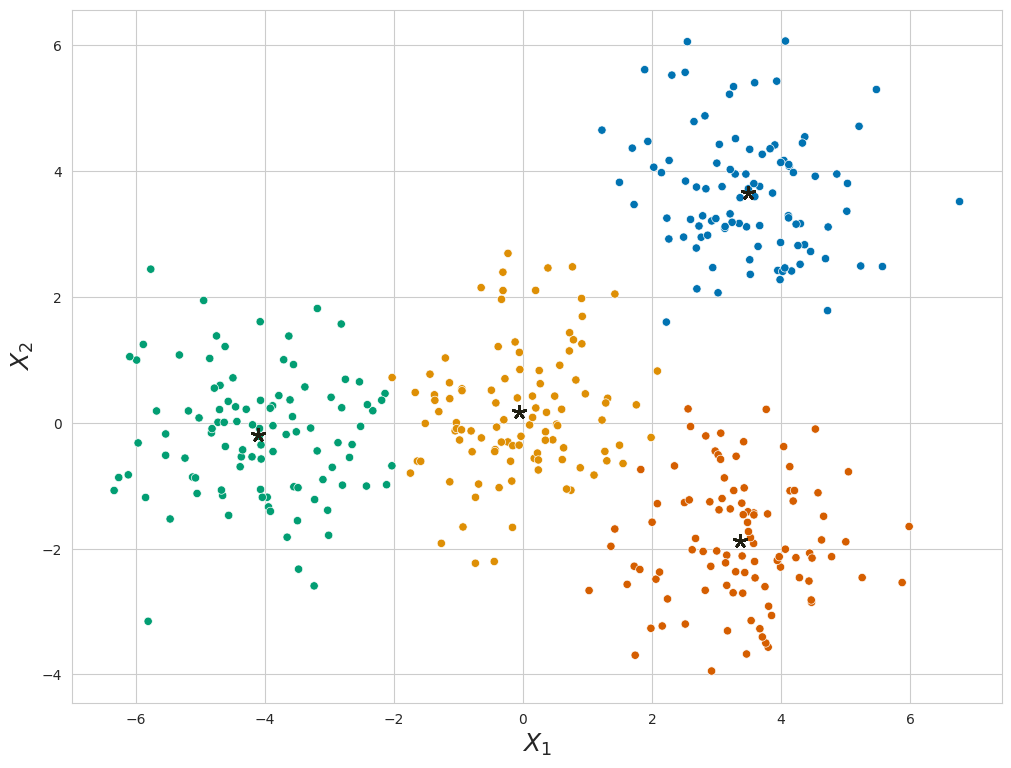

0.564


In [7]:
#сначала фит
mkm = MyKMeans(n_clusters = 4, init="random", max_iter=10, visualize=True)
mkm.fit(X)

#теперь ремикс*, ладно теперь предикт
labels_pred = mkm.predict(X)
#* - шутка типо feat и remix, как будто треки тут исполняем)

#и глянем силуэт
print(f'{silhouette_score(X, labels_pred):1.3}')

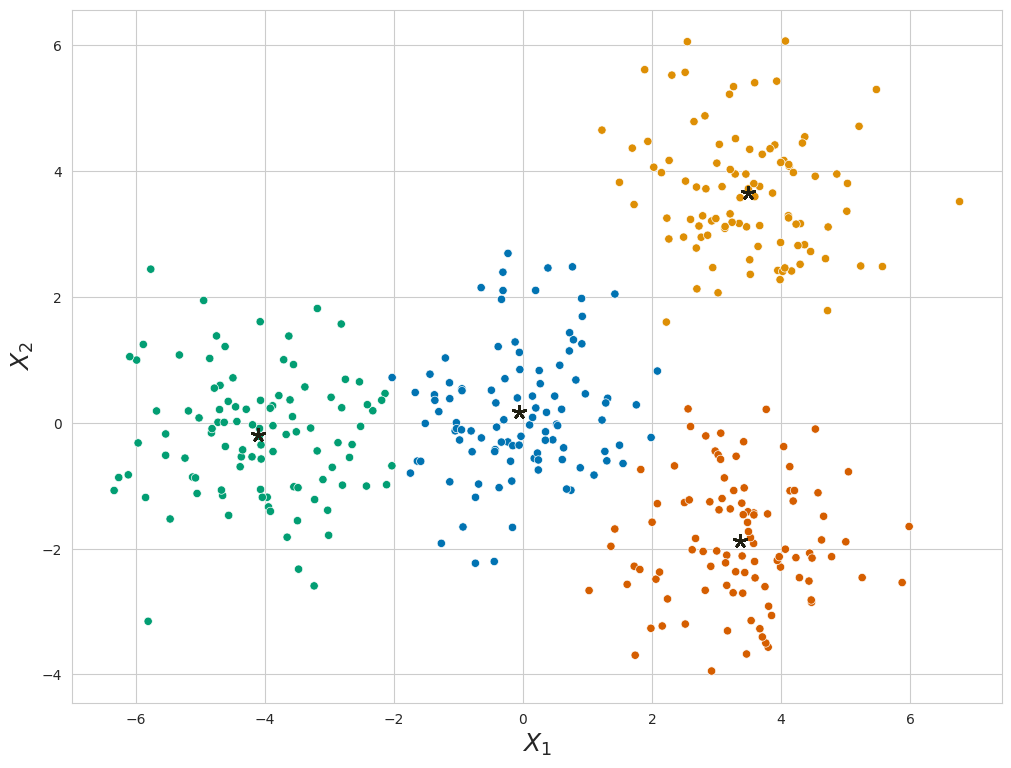

0.564


In [8]:
#то же самое, но для другого типа выбора центроид (среди имеющихся точек)
mkm = MyKMeans(n_clusters = 4, init="sample", max_iter=10, visualize=True)
mkm.fit(X)
labels_pred = mkm.predict(X)
print(f'{silhouette_score(X, labels_pred):1.3}')

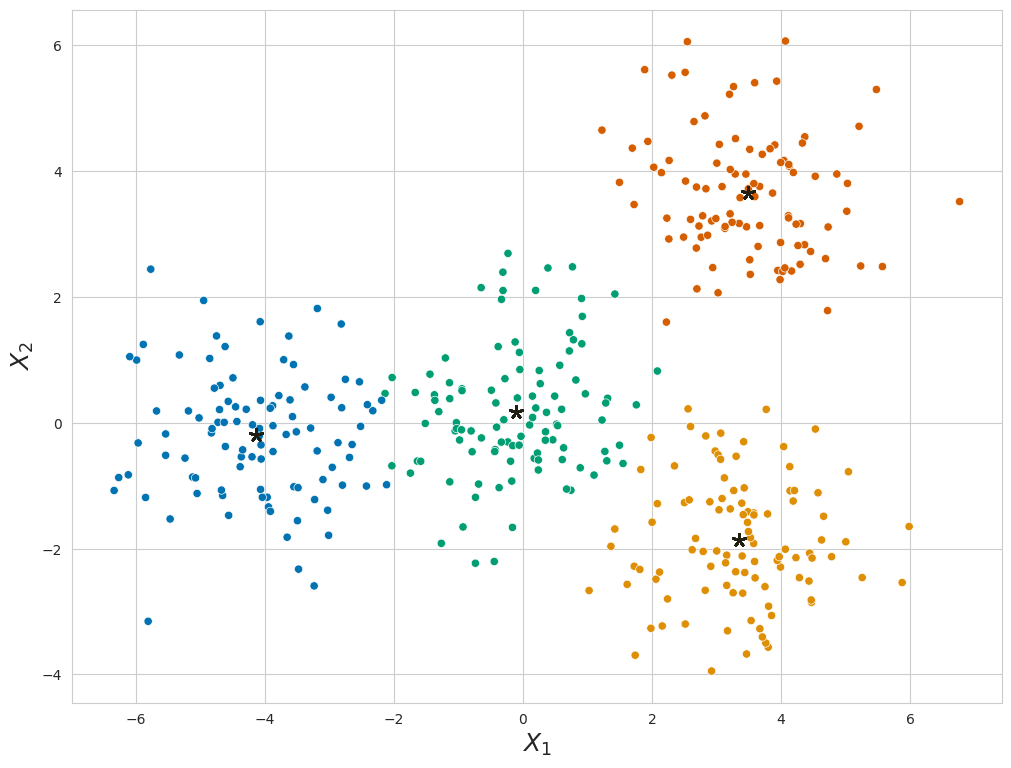

0.564


In [9]:
#а если побольше итераций?
mkm = MyKMeans(n_clusters = 4, init="random", max_iter=100, visualize=True)
mkm.fit(X)
labels_pred = mkm.predict(X)
print(f'{silhouette_score(X, labels_pred):1.3}')

>*Получается нет особенной разницы в конкретно этом примере в методе инициализации начальных центроид. (В значениях метрики силуэт особых различий нет + даже глазками можно глянуть и там кардинально нет изменений). Кстати значение самой метрики не прям топ (ну не 1, но и не -1).*

>*Кстати, если смотреть на сами плоты, то можно увидеть, что некоторые пограничные точки не совсем верно определяются (они исходно принадлежат одному кластеру, но близки к другому). И изменением условий обучения (больше итераций и т.д.) не меняет ситуации, т.к. это чисто ограничение алгоритма.*

In [10]:
#кажется, тут ещё один встроенный лол)
repr(mkm)

'Привет, я твой KMeans (/¯◡ ‿ ◡)/¯☆*'

### Задание 2. Подбираем лучшую иерархическую кластеризацию

5 баллов

На лекции были рассмотрены различные расстояния, которые могут служить метриками различия между объектами. Также мы разобрали несколько алгоритмов кластеризации, в том числе и иерархическую. Часто может быть непонятно, какой алгоритм и какую метрику расстояния нужно взять. Давайте упростим себе жизнь и напишем функцию `algorithm_selection`, которая будет на основании переданных ей:

* метрик расстояния (можно брать все, что было на лекциях, минимум 4)
* параметра `linkage` ('average', 'single', 'complete')
* и метрик качества кластеризации ('Homogeneity', 'Completeness', 'V-measure', 'Silhouette')

будет выводить итоговую таблицу, в которую войдут столбцы:
* distance (метрика расстояния)
* linkage (алгоритм иерархической кластеризации)
* homogenity
* completeness
* v_measure
* silhouette

В результате по этой таблице, нужно сделать вывод о том, какой алгоритм кластеризации и с какими гиперпараметрами лучше всего сработал.

Загрузим наши данные:

In [11]:
data = load_digits()
X, y = data.data, data.target

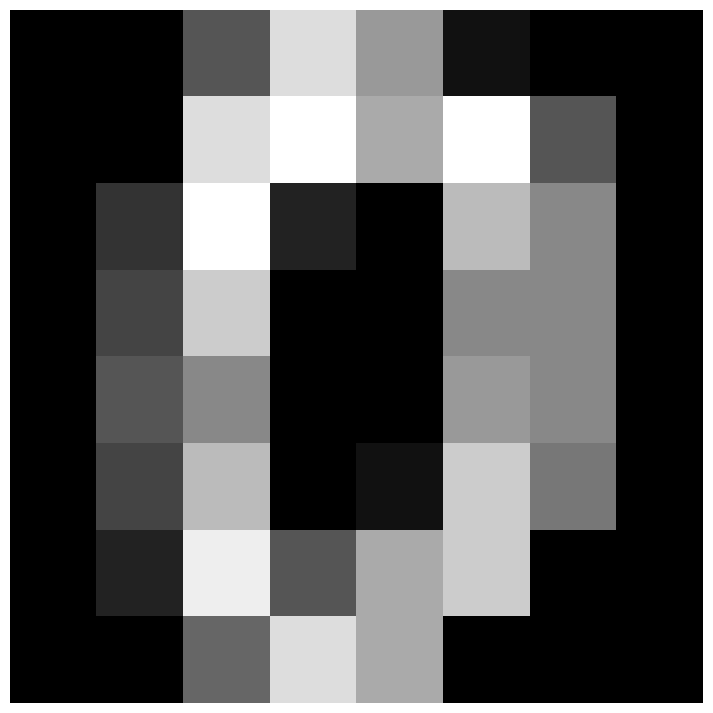

In [12]:
plt.imshow(X[0].reshape(8, 8).astype(int), cmap="gray")
plt.axis("off");

Работать будем с изображениями рукописных цифр. Тут все похоже на данные для 1 домашнего задания, каждая картинка представлена вектором из 64 элементов (числа от 0 до 255). Чтобы ее нарисовать мы должны сделать `reshape` в картинку 8 на 8 пикселей. Вам нужно будет выбрать наилучший способ кластеризации при помощи функции `algorithm_selection`, которую вы реализуете. Для некоторых метрик кластеризации требуются метки **классов** объектов (они хранятся в переменной `y`).

##### YOUR TURN TO CODE

In [13]:
def algorithm_selection(X, y=None, distances=['euclidean', 'manhattan', 'minkowski', 'cosine', 'l1', 'l2'], 
                        algorithms=['average', 'single', 'complete'], metrics=['Homogeneity', 'Completeness', 'V-measure', 'Silhouette'], n=10):
    """
    Для заданных алгоримов кластеризации и гиперпараметров 
    считает различные метрики кластеризации
        :param X: наши данные (n_samples, n_features)
        :param distances: список возможных метрик расстояния
        :param algorithm: параметр linkage ('average', 'single', 'complete')
        :param metrics: список возможных метрик качества кластеризации
    :return compare_dataframe: таблица с метриками кластеризации
    """

    """
    YOUR CODE IS HERE
    """
    #assert distances in ['euclidean', 'l1', 'l2', 'manhattan', 'cosine'], f"Ваши метрики расстояния могут быть только "#переписать под проверку отдельных


    columns_for_df = ['distance', 'linkage']. append(metrics)
    #columns=['distance', 'linkage', 'homogenity', 'completeness', 'v_measure', 'silhouette']
    compare_dataframe = pd.DataFrame(columns=columns_for_df)

    #определим метрики
    homogenity = None
    completeness = None
    v_measure = None
    silhouette = None


#res_dct = dict(map(lambda i: (lst[i], lst[i+1]), range(len(lst)-1)[::2]))
    
    for distance in distances:
        for algorithm in algorithms:#linkage
            #print('distance =',distance, 'linkage =', algorithm)##!!!!
            clustering = AgglomerativeClustering(n_clusters=n, metric=distance, linkage=algorithm)
            labels_pred = clustering.fit_predict(X)
            res = {'distance': distance, 'linkage': algorithm}
            for metric in metrics:
                #print(metric)##!!!!
                match metric:
                    case 'Homogeneity':
                        homogenity = homogeneity_score(y, labels_pred)
                        res['homogenity'] = [homogenity]
                    case 'Completeness':
                        completeness = completeness_score(y, labels_pred)
                        res['completeness'] = [completeness]
                    case 'V-measure':
                        v_measure = v_measure_score(y, labels_pred)
                        res['v_measure'] = [v_measure]
                    case 'Silhouette':
                        silhouette = silhouette_score(X, labels_pred)
                        res['silhouette'] = [silhouette]
                #print(f'distance={distance}, algorithm={algorithm}, metric={metric}')
            
            #res = {'distance': distance, 
                   #'linkage': algorithm, 
                   #'homogenity': [homogenity], 
                   #'completeness': [completeness], 
                   #'v_measure': [v_measure],
                   #'silhouette': [silhouette]}#[] тк If using all scalar values, you must pass an index
            #print(type(res))
            #print(res)
            compare_dataframe = pd.concat([compare_dataframe, pd.DataFrame(res)], ignore_index=True) 
    
    return compare_dataframe

In [14]:
#применяем
res_df = algorithm_selection(X, y)
res_df

distance   linkage  homogenity  completeness  v_measure  silhouette
0   euclidean   average    0.655393      0.782342   0.713263    0.146625
1   euclidean    single    0.005056      0.273755   0.009929   -0.133621
2   euclidean  complete    0.590549      0.637772   0.613253    0.119271
3   manhattan   average    0.566751      0.778942   0.656117    0.089217
4   manhattan    single    0.005102      0.276237   0.010019   -0.166627
5   manhattan  complete    0.646372      0.686109   0.665648    0.140183
6   minkowski   average    0.655393      0.782342   0.713263    0.146625
7   minkowski    single    0.005056      0.273755   0.009929   -0.133621
8   minkowski  complete    0.590549      0.637772   0.613253    0.119271
9      cosine   average    0.648268      0.808762   0.719676    0.129526
10     cosine    single    0.005050      0.273389   0.009916   -0.158250
11     cosine  complete    0.528727      0.577415   0.551999    0.088021
12         l1   average    0.566751      0.778942   0.656117    0.089217
13         l1    single    0.005102      0.276237   0.010019   -0.166627
14         l1  complete    0.646372      0.686109   0.665648    0.140183
15         l2   average    0.655393      0.782342   0.713263    0.146625
16         l2    single    0.005056      0.273755   0.009929   -0.133621
17         l2  complete    0.590549      0.637772   0.613253    0.119271

In [15]:
#что по метрикам топ
print(f'По гомогенности лучший вариант: {res_df.iloc[res_df['homogenity'].idxmax()][0]} {res_df.iloc[res_df['homogenity'].idxmax()][1]}')
print(f'По полноте лучший вариант: {res_df.iloc[res_df['completeness'].idxmax()][0]} {res_df.iloc[res_df['completeness'].idxmax()][1]}')
print(f'По v-мере лучший вариант: {res_df.iloc[res_df['v_measure'].idxmax()][0]} {res_df.iloc[res_df['v_measure'].idxmax()][1]}')
print(f'По силуэту лучший вариант: {res_df.iloc[res_df['silhouette'].idxmax()][0]} {res_df.iloc[res_df['silhouette'].idxmax()][1]}')

По гомогенности лучший вариант: euclidean average
По полноте лучший вариант: cosine average
По v-мере лучший вариант: cosine average
По силуэту лучший вариант: euclidean average


>Получается лучший linkage-метод average.
>Что касается расстояний, то по гомогенности и силуэту лучшие euclidean, minkowski, l1 (последние два равные значения метрики имеют); по полноте и v-мере - cosine. 

> *Hint (для меня):  homogenity (\[0; 1]) completeness (\[0; 1])	v_measure(\[0; 1])	silhouette(\[-1;1]). Для всех лучшее значение 1.*
>
> [метрики](https://education.yandex.ru/handbook/ml/article/klasterizaciya)

In [16]:
#Пример: применяем, но с настройками как хотим
res_df = algorithm_selection(X, y, distances=['euclidean', 'manhattan'], 
                        algorithms=['average', 'complete'], metrics=['V-measure', 'Silhouette'], n=10)
res_df

distance   linkage  v_measure  silhouette
0  euclidean   average   0.713263    0.146625
1  euclidean  complete   0.613253    0.119271
2  manhattan   average   0.656117    0.089217
3  manhattan  complete   0.665648    0.140183

### Задание 3. Аннотация клеточных типов

суммарно 10 баллов

В этом задании вам предстоит применять полученные знания о кластеризации для аннотации данных, полученных при помощи проточной цитометрии. Каждая строка в данных это одна клетка, столбцы **FSC-A**, **SSC-A** косвенным образом свидетельствуют о размере клеток, остальные показывают интенсивность флуоресценции различных поверхностных маркеров. Ваша задача определить для каждой клетки, к какому типу она относится.

#### 3.1. EDA

1.5 балла

Проведите EDA:

1. Посмотрите на данные (можно попробовать метод `describe`)
2. Сколько у нас клеток / признаков
3. Постройте распределения каждого признака (есть ли очевиднные выбросы?)

In [11]:
fc_data = pd.read_csv(join(DATA_PATH, "flow_c_data.csv"), index_col=0)

##### YOUR TURN TO CODE:

In [12]:
#глянем в целом что есть
fc_data.head()

FSC-A     SSC-A    HLA-DR       CD3      CD45      CD14      CD56  \
0  0.722199  0.154232  0.494449  0.512853  4.057328  1.019255  4.007273   
1  0.751073  0.114618  4.671924  0.822042  4.933149  0.159388 -0.216407   
2  1.108188  0.150011 -0.422857  4.006353  5.616384  0.519223  0.783077   
3  0.553310  0.119929  0.345968  3.332310  5.260935  1.481229  0.264846   
4  0.774884  0.076984  4.984963  0.885501  4.562367  0.217117  0.086279   

       CD19     CD11c  
0 -1.406912  0.384406  
1  6.034845  0.577039  
2 -0.318668 -0.493832  
3  0.694883  3.416960  
4  5.563345  0.471591

In [13]:
#сводку
fc_data.describe()
#ну понятно, разные фичи в разных интервалах значений => будем стандартизовать

FSC-A         SSC-A        HLA-DR           CD3          CD45  \
count  10000.000000  10000.000000  10000.000000  10000.000000  10000.000000   
mean       0.962458      0.165415      1.791579      3.280391      5.169845   
std        0.500012      0.190773      2.027281      2.112079      0.518247   
min        0.144786      0.021657     -7.634172     -2.517639     -8.329666   
25%        0.798804      0.105550      0.275056      1.401943      4.922227   
50%        0.908574      0.130543      1.194313      4.373660      5.234119   
75%        1.052034      0.162536      3.696976      4.842212      5.481218   
max       42.954485     15.460997     12.946668     13.844391     13.710922   

               CD14          CD56          CD19         CD11c  
count  10000.000000  10000.000000  10000.000000  10000.000000  
mean       1.097182      0.412223      1.219683      0.569898  
std        1.375876      1.176967      2.285305      1.502445  
min       -8.833883    -12.358701     -9.640775    -11.085437  
25%        0.389746     -0.195978     -0.146948     -0.498781  
50%        0.672853      0.053267      0.244121      0.272297  
75%        1.065076      0.378576      0.908374      1.220576  
max        6.294236      6.461899      7.208721      6.840864

In [14]:
print(f'Клеток {fc_data.shape[0]} и фичей {fc_data.shape[1]}')#2 "рамера" + маркеры

Клеток 10000 и фичей 9


In [15]:
#чекнем типы ещё (ну и наны от сюда ясны будут (что их не будет => ничего с ними не делаем)):
fc_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   FSC-A   10000 non-null  float64
 1   SSC-A   10000 non-null  float64
 2   HLA-DR  10000 non-null  float64
 3   CD3     10000 non-null  float64
 4   CD45    10000 non-null  float64
 5   CD14    10000 non-null  float64
 6   CD56    10000 non-null  float64
 7   CD19    10000 non-null  float64
 8   CD11c   10000 non-null  float64
dtypes: float64(9)
memory usage: 781.2 KB


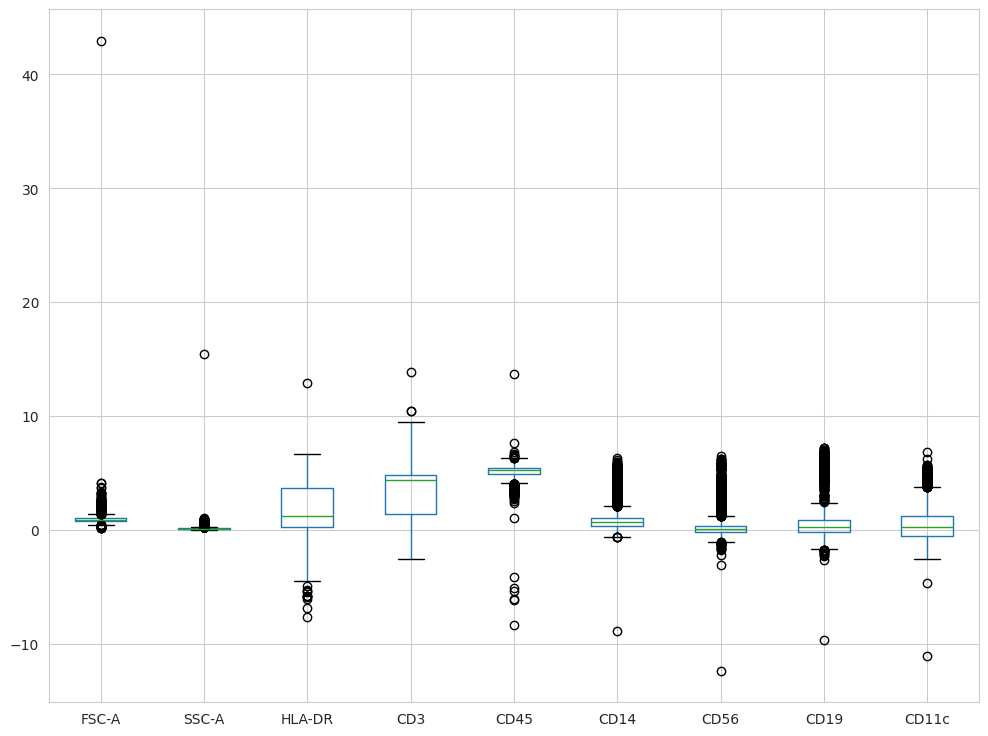

In [16]:
fc_data.boxplot();

>*Есть несколько точек, которые кажутся выбросами (в FSC-A и SSC-A). У других есть точки за пределами полуторных межквартильных размахов. Но первые 2 переменные прям совсем далеко. => давайте выкинем этот точно (на самом деле по размерам там один образец так улетел). И чутка другие почистим.*

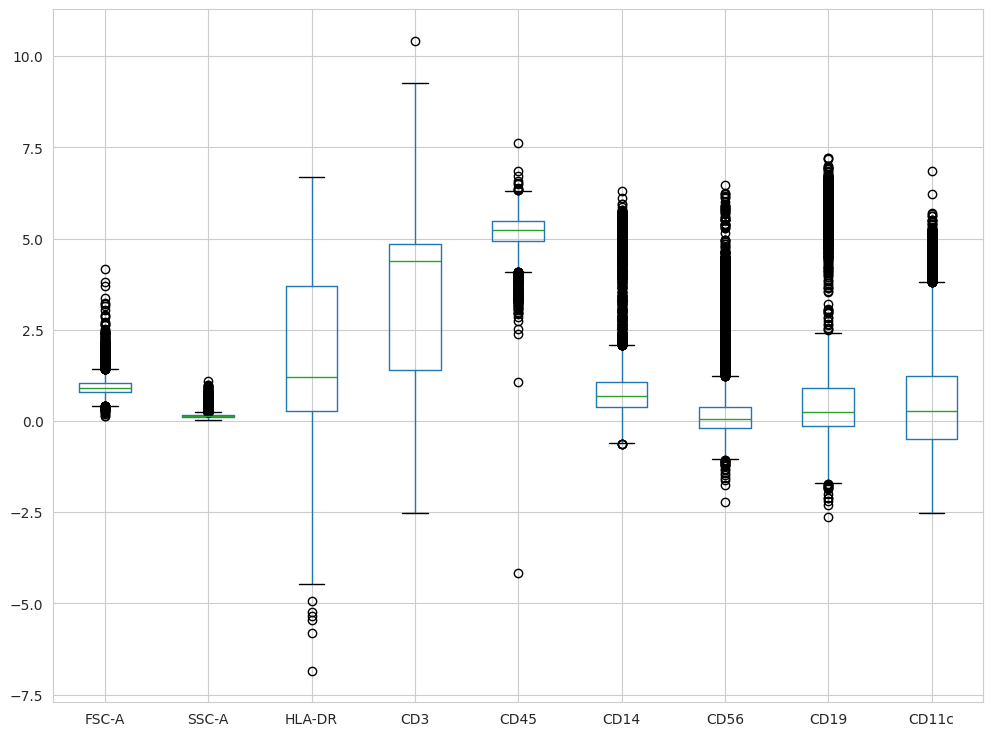

In [18]:
#сделаем отдельный df без выбросов
orig_fc_data = fc_data.copy()#сохраним исходный, пригодится
fc_data_wo_outl = fc_data[((fc_data['FSC-A'] <= 10) & 
                           (fc_data['SSC-A'] <= 10) &
                           (fc_data['CD56'] >= -10) &
                           (fc_data['CD11c'] >= -10) &
                           (fc_data['CD45'] >= -5))]
fc_data_wo_outl.boxplot();

In [19]:
print(f'Убрали {fc_data.shape[0] - fc_data_wo_outl.shape[0]} образцов')

Убрали 6 образцов


In [20]:
#скейлим
scaler = StandardScaler()
fc_data_wo_outl_sc = scaler.fit_transform(fc_data_wo_outl)
#fc_data_wo_outl_sc

#### 3.2. Кластеризация

4.5 балла

При ручной аннотации клеточных типов обычно поступают следующим образом:

1. При помощи методов понижения размерности рисуют наши наблюдения, чтобы примерно оценить число клеточных типов
2. Проводят кластеризацию наблюдений (для некоторых методов нужно заранее задать число кластеров, поэтому нам как раз помогает п.1)
3. Далее мы считаем, что клетки, которые алгоритм отнес к одному кластеру являются одним клеточным типом (если кластеров больше, чем типов клеток, то возможно, что 2 разных кластера являются одним типом)
4. После чего по интенсивности экспрессии поверхностных маркеров мы присваиваем кластеру клеточный тип

Давайте для начала напишем удобную функцию для визуализации наших многомерных данных в пространстве размерностью 2, делать мы это будем при помощи алгоритма t-SNE.

Поиграться с красивой визуализацией можно [тут](https://distill.pub/2016/misread-tsne/).

In [22]:
def plot_tsne(data, n_iter=1000, 
              perplexity=40, color=None):
    """
    Функция для отрисовки результатов работы t-SNE
        :param data: таблица объекты х признаки
        :param n_iter: число итераций градиентного спуска,
            может быть полезно увеличить, чтобы получить результаты получше
        :param perplexity: 
        :param color: np.array[n_samples] с переменной,
            которой мы хотим покрасить наши наблюдения
        :return tsne_emb: np.array[n_samples, 2] - результаты работы t-SNE
    """
    
    # Сначала сделаем PCA, так как это хорошее начальное приближение для t-SNE
    # позволит алгоритму быстрее сойтись
    pca = PCA().fit(data)
    pca_embedding = pca.transform(data)
    
    # Запустим t-SNE, он выдаст нам для каждого объекта по 2 числа, 
    # которые мы сможем нарисовать
    tnse = TSNE(n_components=2, init=pca_embedding[:, :2], n_jobs=-1,
                n_iter=n_iter, perplexity=perplexity)
    tsne_embedding = tnse.fit_transform(pca_embedding)
    
    sns.scatterplot(x=tsne_embedding[:, 0],
                    y=tsne_embedding[:, 1],
                    hue=color, palette="colorblind")
    plt.xlabel("$TSNE_1$", fontsize=18)
    plt.ylabel("$TSNE_2$", fontsize=18)
    
    # Вернем также результаты t-SNE, так как, если потом захотим перестроить картинку,
    # в таком случае нам не придется ждать заново, просто нарисуем новую с готовыми данными
    
    return tsne_embedding

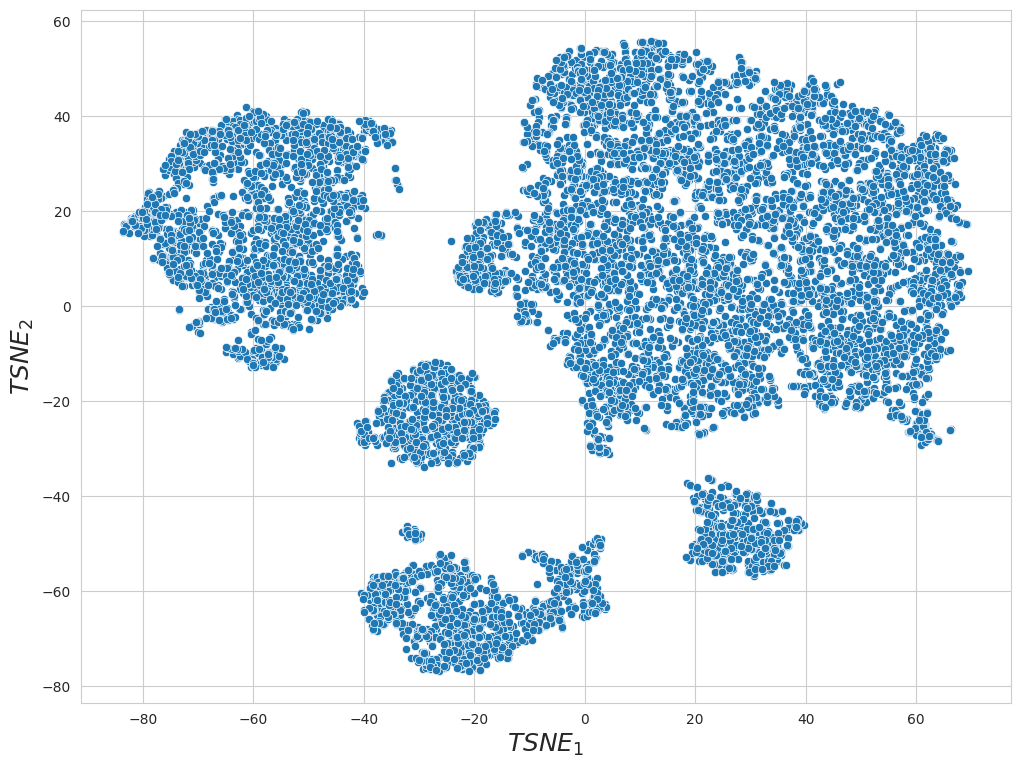

In [27]:
#без стандартизации глянем
tsne_res = plot_tsne(fc_data)
#тут что-то около 5 кластеров

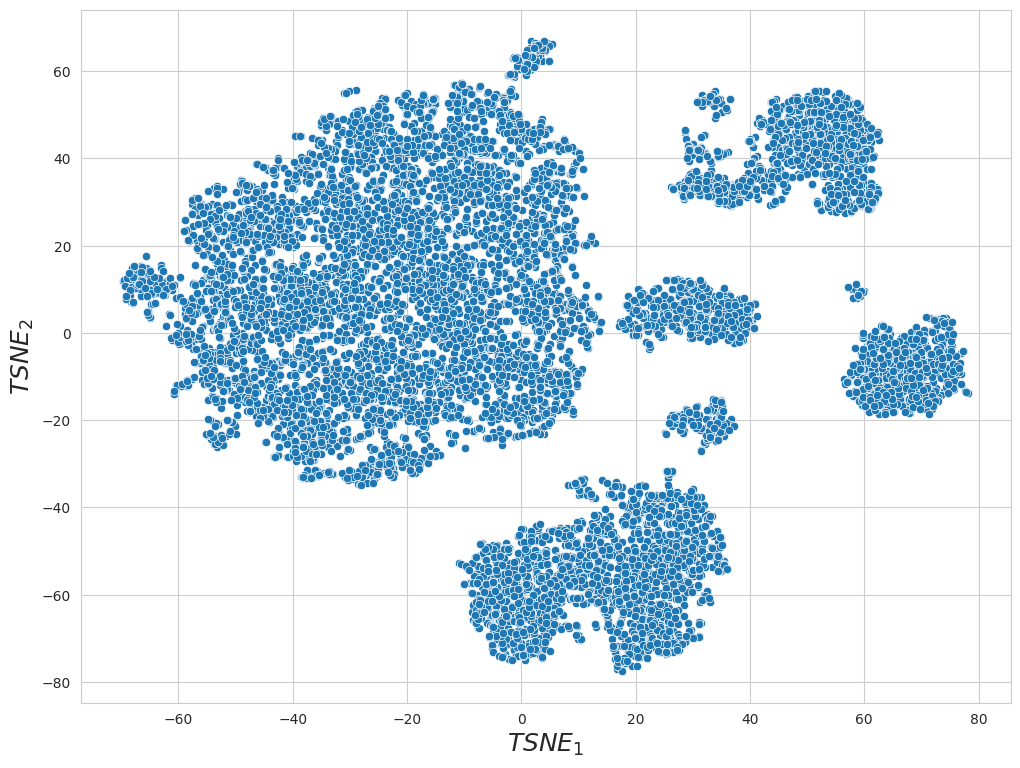

In [28]:
#но мы то договорились работать с отшкалированными
tsne_res = plot_tsne(fc_data_wo_outl_sc)

>*Я бы сказала, что здесь 6 кластеров, но в некоторых местах есть небольшие скопления точек, которые могли бы быть кластерами тоже.*
>*Не очень разбираюсь за проточную цитометрию, но что видела в статьях: есть и так, и так. В плане, когда маленькие кластеры считаются за отдельные и, когда остаются вместе с большими. Но мы начнём с принципа экономии мышления и возьмём 6.* 


Кластеризуйте ваши данные:

1. Попробуйте методы кластеризации из тех, что мы прошли
2. Выберите лучший на основании метрики `silhouette_score` (попробуйте также подобрать гиперпараметры)
3. Присвойте каждому наблюдению метку класса и нарисуйте график t-SNE, покрасив точки метками кластера

>**Kmeans**

In [29]:
#можно тоже сделать функцию (как во 2 задании)
def kmeans_selection(X, n=[6], max_iter=[300], random_state=None, algorithms=['lloyd', 'elkan']):
    
    columns_for_df = ['n_clusters', 'max_iter', 'algorithm', 'silhouette']
    compare_dataframe = pd.DataFrame(columns=columns_for_df)
    
    for nclust in n:
        for iter_num in max_iter:
            for algorithm in algorithms:
                print(f'n={nclust}, iter_num={iter_num}, algorithm={algorithm}')
                kmeans = KMeans(n_clusters=nclust, max_iter=iter_num, random_state=random_state, algorithm=algorithm)#.fit(fc_data_wo_outl_sc)
                labels_pred = kmeans.fit_predict(X)
                silhouette = silhouette_score(X, labels_pred)
                res = {'n_clusters': nclust, 'max_iter': iter_num, 'algorithm': algorithm, 'silhouette': [silhouette]}
                compare_dataframe = pd.concat([compare_dataframe, pd.DataFrame(res)], ignore_index=True) 
    
    return compare_dataframe

In [30]:
#если будете запускать, то может считаться долго (можно вариантов гиперпараметров поменьше взять)
res_df_km = kmeans_selection(fc_data_wo_outl_sc, n=[4, 5, 6, 7], max_iter=[10, 100, 300], random_state=SEED)

print(f'По силуэту лучший вариант: n_clusters={res_df_km.iloc[res_df_km['silhouette'].idxmax()][0]} max_iter={res_df_km.iloc[res_df_km['silhouette'].idxmax()][1]} algorithm={res_df_km.iloc[res_df_km['silhouette'].idxmax()][2]}')
(res_df_km.sort_values(by=['silhouette'], ascending=False)).head()#выведем топ-5 по метрике

По силуэту лучший вариант: n_clusters=5 max_iter=10 algorithm=lloyd


n_clusters max_iter algorithm  silhouette
6           5       10     lloyd    0.517165
7           5       10     elkan    0.517165
8           5      100     lloyd    0.517165
9           5      100     elkan    0.517165
10          5      300     lloyd    0.517165

0.517


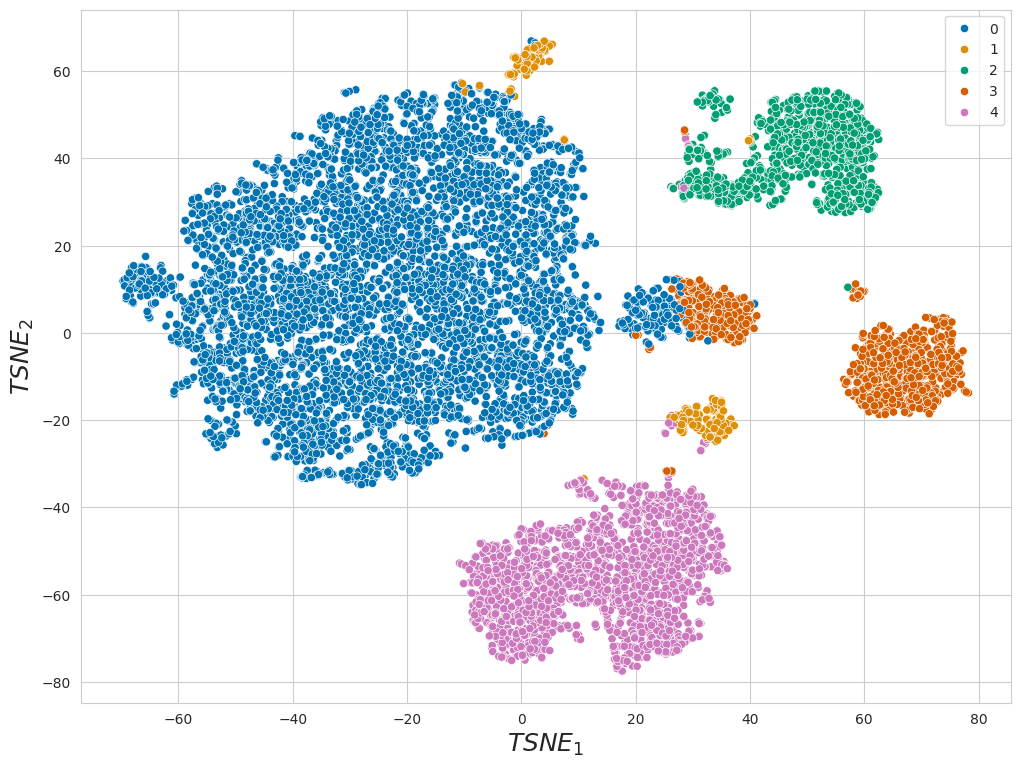

In [34]:
#лучший по силуэту строим
kmeans = KMeans(n_clusters=5, max_iter=10, random_state=SEED, algorithm='lloyd').fit(fc_data_wo_outl_sc)
cluster_pred = kmeans.predict(fc_data_wo_outl_sc)
print(f'{silhouette_score(fc_data_wo_outl_sc, cluster_pred):1.3}')

tsne_res = plot_tsne(fc_data_wo_outl_sc, color=cluster_pred)

> В кластер №0 попала часть другого облачка точек. В кластер №1 попали разные облачка. Кластер №2 неплохо вышел, но там есть отдельные точки из других. Кластер №3 тоже несколько облачков забрал. Кластер №4 красавчик, но есть вкрапления 3. Но в целом как будто норм. (плюс поправка, что визуализация и кластеризация не одно и то же

0.436


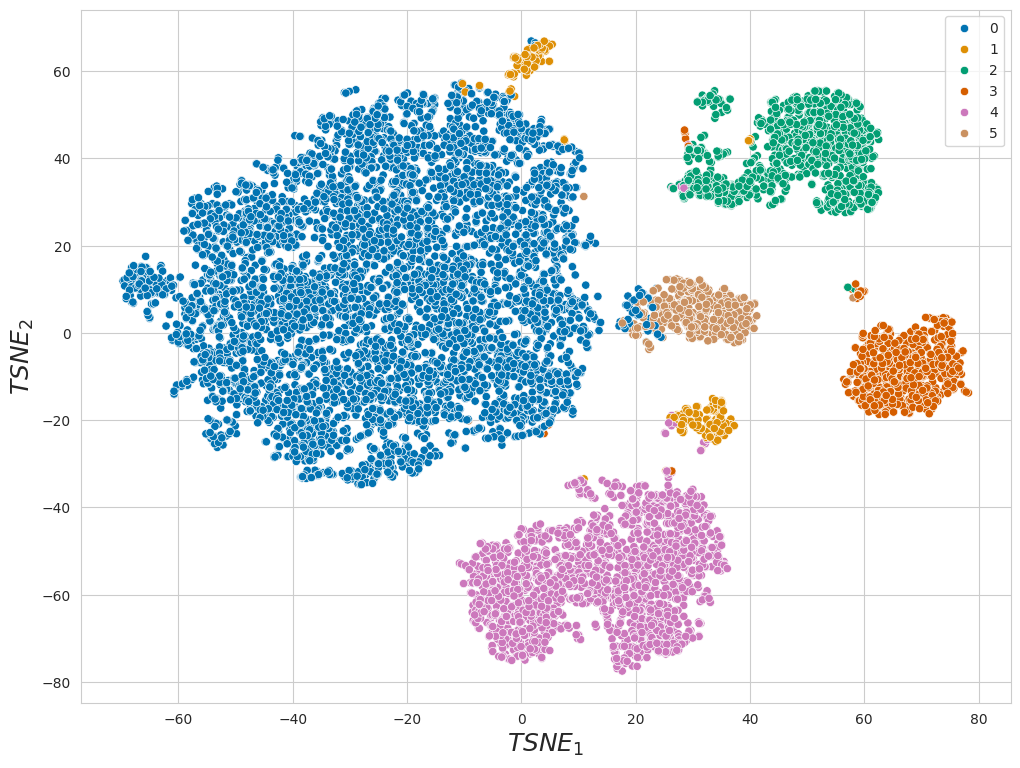

In [35]:
#Глянем на вариант с 6 кластерами всё-таки
kmeans = KMeans(n_clusters=6, random_state=SEED).fit(fc_data_wo_outl_sc)
cluster_pred = kmeans.predict(fc_data_wo_outl_sc)
print(f'{silhouette_score(fc_data_wo_outl_sc, cluster_pred):1.3}')

tsne_res = plot_tsne(fc_data_wo_outl_sc, color=cluster_pred)

>Облачко (кластер №5 здесь) отделилось от единого кластера на прошлом варианте (кластер №3 на прошлой картинке). 

>**Agglomerative clustering**

In [33]:
#5agglomerative clustering
res_df_ac = algorithm_selection(X=fc_data_wo_outl_sc, metrics=['Silhouette'], n=5)

print(f'По силуэту лучший вариант: distance={res_df_ac.iloc[res_df_ac['silhouette'].idxmax()][0]} linkage={res_df_ac.iloc[res_df_ac['silhouette'].idxmax()][1]}')
res_df_ac

distance = euclidean linkage = average
distance = euclidean linkage = single
distance = euclidean linkage = complete
distance = manhattan linkage = average
distance = manhattan linkage = single
distance = manhattan linkage = complete
distance = minkowski linkage = average
distance = minkowski linkage = single
distance = minkowski linkage = complete
distance = cosine linkage = average
distance = cosine linkage = single
distance = cosine linkage = complete
distance = l1 linkage = average
distance = l1 linkage = single
distance = l1 linkage = complete
distance = l2 linkage = average
distance = l2 linkage = single
distance = l2 linkage = complete
По силуэту лучший вариант: euclidean average


distance   linkage  silhouette
0   euclidean   average    0.568014
1   euclidean    single    0.562648
2   euclidean  complete    0.290187
3   manhattan   average    0.543232
4   manhattan    single    0.509706
5   manhattan  complete    0.425156
6   minkowski   average    0.568014
7   minkowski    single    0.562648
8   minkowski  complete    0.290187
9      cosine   average    0.361839
10     cosine    single   -0.357886
11     cosine  complete    0.108830
12         l1   average    0.543232
13         l1    single    0.509706
14         l1  complete    0.425156
15         l2   average    0.568014
16         l2    single    0.562648
17         l2  complete    0.290187

In [36]:
#agglomerative clustering
res_df_ac = algorithm_selection(X=fc_data_wo_outl_sc, metrics=['Silhouette'], n=6)

print(f'По силуэту лучший вариант: distance={res_df_ac.iloc[res_df_ac['silhouette'].idxmax()][0]} linkage={res_df_ac.iloc[res_df_ac['silhouette'].idxmax()][1]}')
(res_df_ac.sort_values(by=['silhouette'], ascending=False)).head()

По силуэту лучший вариант: distance=euclidean linkage=single


distance  linkage  silhouette
16         l2   single    0.560186
7   minkowski   single    0.560186
1   euclidean   single    0.560186
0   euclidean  average    0.559192
6   minkowski  average    0.559192

>Несколько вариантов одинаково хороши по метрике, возьмём самый простой euclidean-average

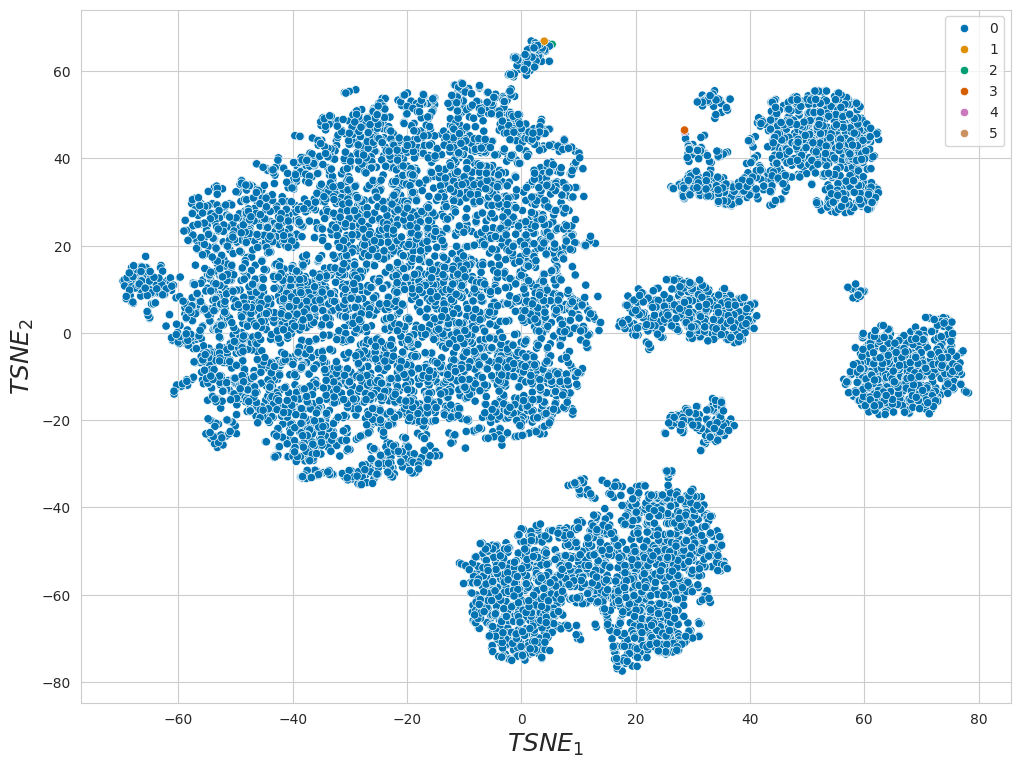

In [40]:
#и визуализация
clustering = AgglomerativeClustering(n_clusters=6, metric='euclidean', linkage='single')
cluster_pred = clustering.fit_predict(fc_data_wo_outl_sc)
tsne_res = plot_tsne(fc_data_wo_outl_sc, color=cluster_pred)

>ТОП. Шутка конечно.  Полнота тут, наверно, почти 1 была бы (типо почти все в одном кластере). Зато гомогенность должна страдать, но разметки нет, поэтому эти метрики не попробовать.

In [42]:
#даже интересно посмотреть сколько в какой кластер клеток разкластеризовалось:
np.unique(cluster_pred, return_counts=True) #ну да, всё в одном 

(array([0, 1, 2, 3, 4, 5]), array([9989,    1,    1,    1,    1,    1]))

>давайте визуализируем парочку других вариантов расстояния (но будем брать лучшие по силуэту в своей группе)

In [41]:
res_df_ac #фулл табличка, чтобы выбирать

distance   linkage  silhouette
0   euclidean   average    0.559192
1   euclidean    single    0.560186
2   euclidean  complete    0.273170
3   manhattan   average    0.491821
4   manhattan    single    0.508298
5   manhattan  complete    0.420107
6   minkowski   average    0.559192
7   minkowski    single    0.560186
8   minkowski  complete    0.273170
9      cosine   average    0.320331
10     cosine    single   -0.363064
11     cosine  complete    0.086769
12         l1   average    0.491821
13         l1    single    0.508298
14         l1  complete    0.420107
15         l2   average    0.559192
16         l2    single    0.560186
17         l2  complete    0.273170

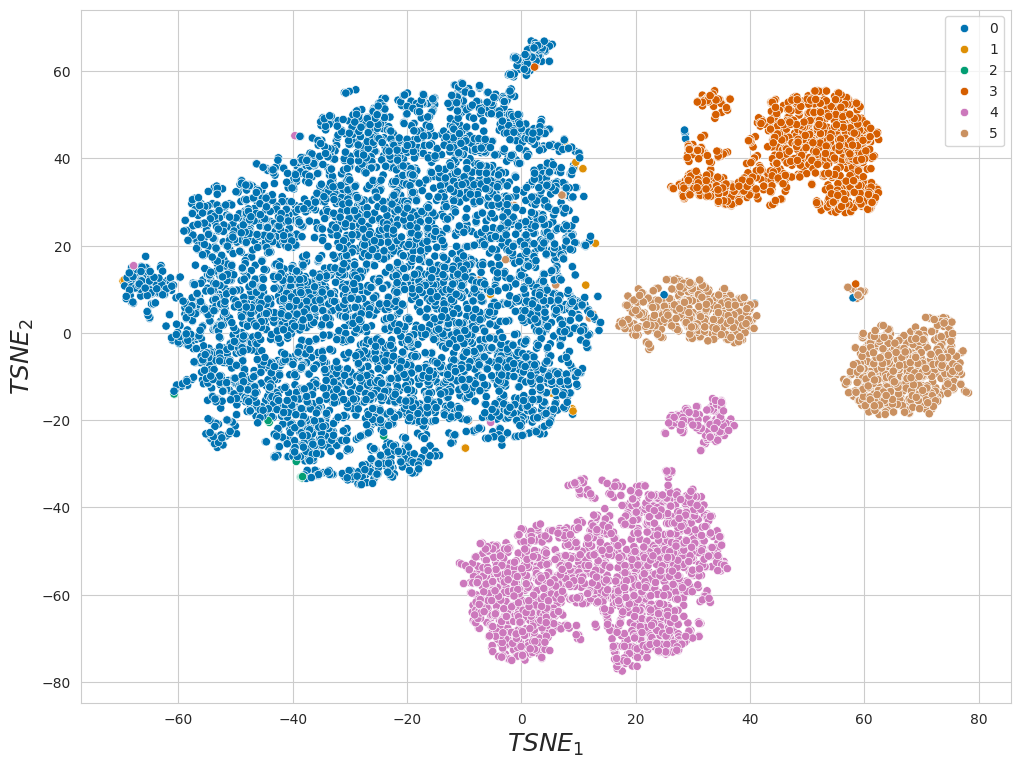

In [42]:
clustering = AgglomerativeClustering(n_clusters=6, metric='cosine', linkage='average')
cluster_pred = clustering.fit_predict(fc_data_wo_outl_sc)
tsne_res = plot_tsne(fc_data_wo_outl_sc, color=cluster_pred)
#уже лучше

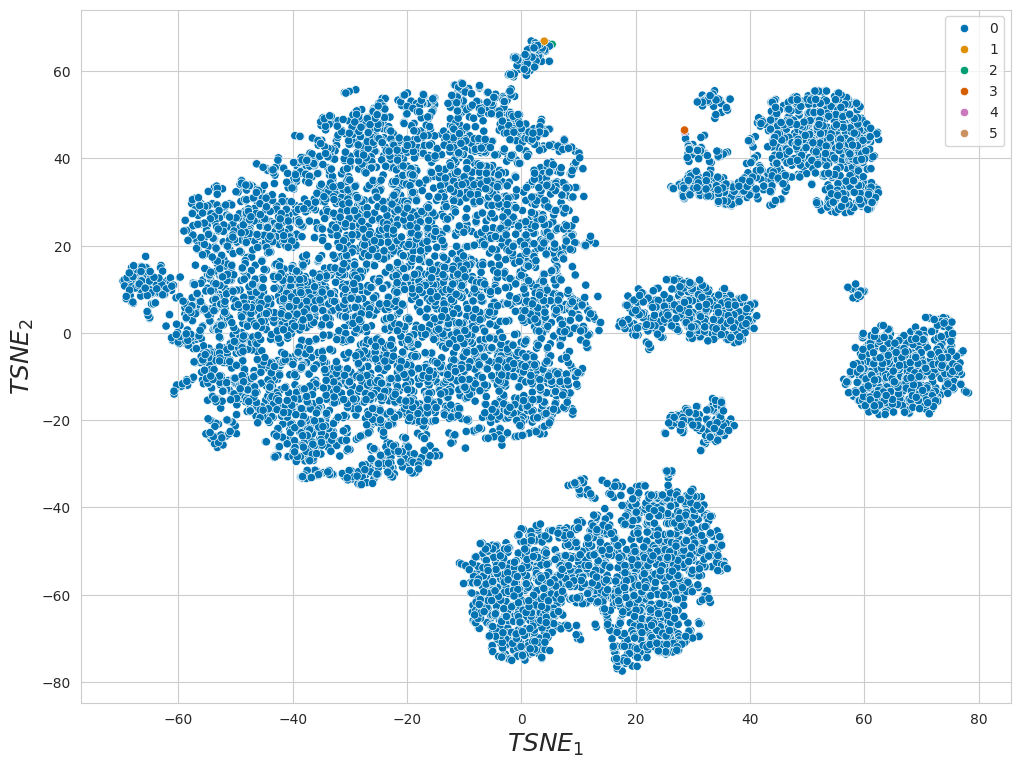

In [43]:
clustering = AgglomerativeClustering(n_clusters=6, metric='minkowski', linkage='single')
cluster_pred = clustering.fit_predict(fc_data_wo_outl_sc)
tsne_res = plot_tsne(fc_data_wo_outl_sc, color=cluster_pred)
#провал

>Здесь всё-таки в случае cosine получилось покрасить более менее точки по облачкам.

>**DBSCAN**


In [44]:
#давайте здесь тоже перепишем чутка функцию подбора
def dbscan_selection(X, epsilons=[2, 3, 5, 10], min_samples =[5, 10, 50], 
                     distances=['euclidean', 'manhattan']):
    
    columns_for_df = ['metric','min_samples', 'eps', 'silhouette']
    compare_dataframe = pd.DataFrame(columns=columns_for_df)
    
    for distance in distances:
        for min_samp in min_samples:
            for epsilon in epsilons:
                print(f'distance={distance}, min_samp={min_samp}, epsilon={epsilon}')
                clustering = DBSCAN(eps=epsilon, min_samples=min_samp, metric=distance)
                labels_pred = clustering.fit_predict(X)
                #print(f'X {X.shape}, labels_pred {labels_pred.shape}')
                silhouette = silhouette_score(X, labels_pred)#, metric=distance)
                res = {'metric': distance, 'min_samples': min_samp, 'eps': epsilon, 'silhouette': [silhouette]}
                compare_dataframe = pd.concat([compare_dataframe, pd.DataFrame(res)], ignore_index=True) 
    
    return compare_dataframe

In [47]:
res_df_dbs = dbscan_selection(fc_data_wo_outl_sc)

print(f'По силуэту лучший вариант: metric={res_df_dbs.iloc[res_df_dbs['silhouette'].idxmax()][0]} min_samples={res_df_dbs.iloc[res_df_dbs['silhouette'].idxmax()][1]} eps={res_df_dbs.iloc[res_df_dbs['silhouette'].idxmax()][2]}')
(res_df_dbs.sort_values(by=['silhouette'], ascending=False)).head()#покажем только топ 5, а то табличка длинная (не оч красиво и нам нужны лучшие же)

distance=euclidean, min_samp=5, epsilon=2
distance=euclidean, min_samp=5, epsilon=3
distance=euclidean, min_samp=5, epsilon=5
distance=euclidean, min_samp=5, epsilon=10
distance=euclidean, min_samp=10, epsilon=2
distance=euclidean, min_samp=10, epsilon=3
distance=euclidean, min_samp=10, epsilon=5
distance=euclidean, min_samp=10, epsilon=10
distance=euclidean, min_samp=50, epsilon=2
distance=euclidean, min_samp=50, epsilon=3
distance=euclidean, min_samp=50, epsilon=5
distance=euclidean, min_samp=50, epsilon=10
distance=manhattan, min_samp=5, epsilon=2
distance=manhattan, min_samp=5, epsilon=3
distance=manhattan, min_samp=5, epsilon=5
distance=manhattan, min_samp=5, epsilon=10
distance=manhattan, min_samp=10, epsilon=2
distance=manhattan, min_samp=10, epsilon=3
distance=manhattan, min_samp=10, epsilon=5
distance=manhattan, min_samp=10, epsilon=10
distance=manhattan, min_samp=50, epsilon=2
distance=manhattan, min_samp=50, epsilon=3
distance=manhattan, min_samp=50, epsilon=5
distance=manha

metric min_samples eps  silhouette
2   euclidean           5   5    0.829116
3   euclidean           5  10    0.829116
19  manhattan          10  10    0.829116
6   euclidean          10   5    0.829116
7   euclidean          10  10    0.829116

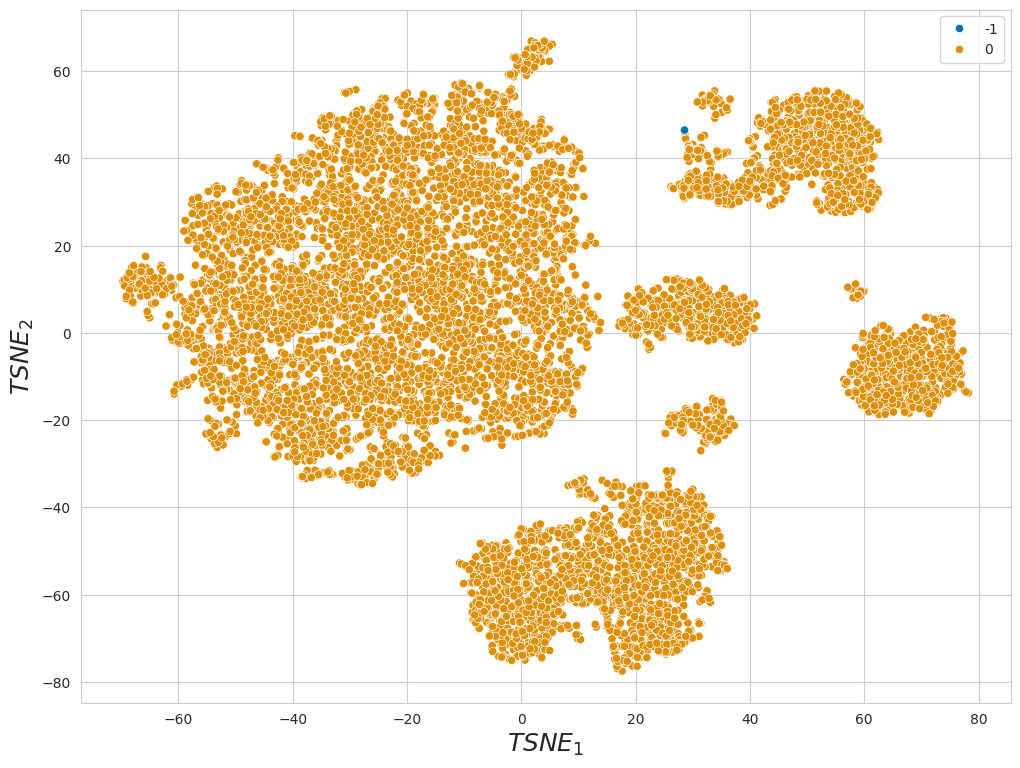

In [59]:
#визуализируем лучший (самый простой из лучших)
dbs_clustering = DBSCAN(eps=5, metric='euclidean', min_samples=5)
cluster_pred = dbs_clustering.fit_predict(fc_data_wo_outl_sc)
tsne_res = plot_tsne(fc_data_wo_outl_sc, color=cluster_pred)

>ну не получилось тут совсем

Удалось ли вам получить ситуацию, где отдельные группы точек покрашены в один цвет?

> В общем, если визуально оценивать, более менее справились KMeans и агломеративная кластеризация (с расстоянием cosine). Нам дальше нужно будет найти только 4 кластера. Сравним по силуэту и возьмём лучший для дальнейшей работы: KMeans (2 нижние ячейки с расчётом)

In [52]:
#выбор kmeans для 4
(res_df_km[res_df_km['n_clusters'] == 4].sort_values(by=['silhouette'], ascending=False)).head(3)
#одинаково 0.507953 для всех

n_clusters max_iter algorithm  silhouette
0          4       10     lloyd    0.507953
1          4       10     elkan    0.507953
2          4      100     lloyd    0.507953

In [55]:
#выбор агломеративной для 4
res_df_ac = algorithm_selection(X=fc_data_wo_outl_sc, distances=['cosine'], metrics=['Silhouette'], n=4)
(res_df_ac.sort_values(by=['silhouette'], ascending=False)).head(3)
#топ 0.482284. => возьмём KMeans

distance   linkage  silhouette
0   cosine   average    0.482284
2   cosine  complete    0.090055
1   cosine    single   -0.349964

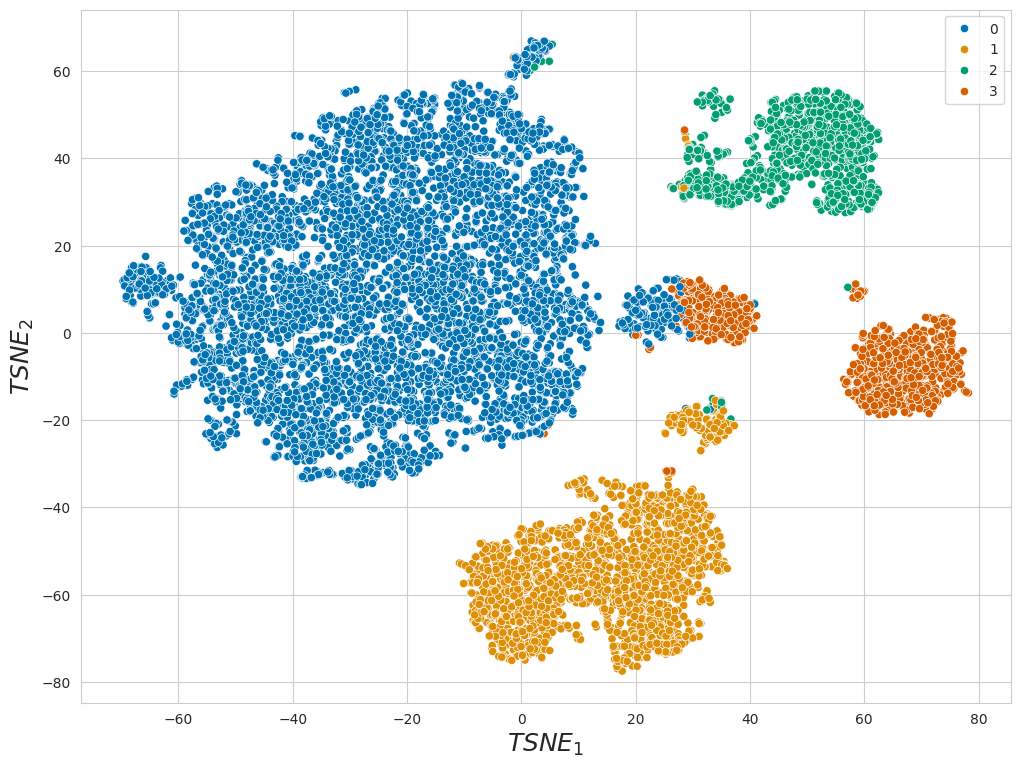

In [37]:
#выбранный ещё раз прогонем для дальнейшей работы (клеточных типов ниже 4, кол-во кластеров так и зададим)
clust = KMeans(n_clusters=4, random_state=SEED).fit(fc_data_wo_outl_sc)
cluster_pred = clust.predict(fc_data_wo_outl_sc)

tsne_res = plot_tsne(fc_data_wo_outl_sc, color=cluster_pred)

fc_data = fc_data_wo_outl

#### 3.3. Аннотация клеточных типов

4 балла

Теперь когда мы подобрали хороший алгоритм кластеризации, можно аннотировать наши клетки. Для этого мы нарисуем t-SNE и покрасим точки в зависимости от интенсивности экспрессии поверхностных маркеров. В датасете присутствуют следующие типы клеток:

* B_cells
* T_cells
* Monocytes
* Other cells

Вам нужно будет выяснить, какие клетки экспрессируют определенные маркеры и присвоить каждому кластеру один из типов клеток.

Для начала нарисуем все это безобразие:

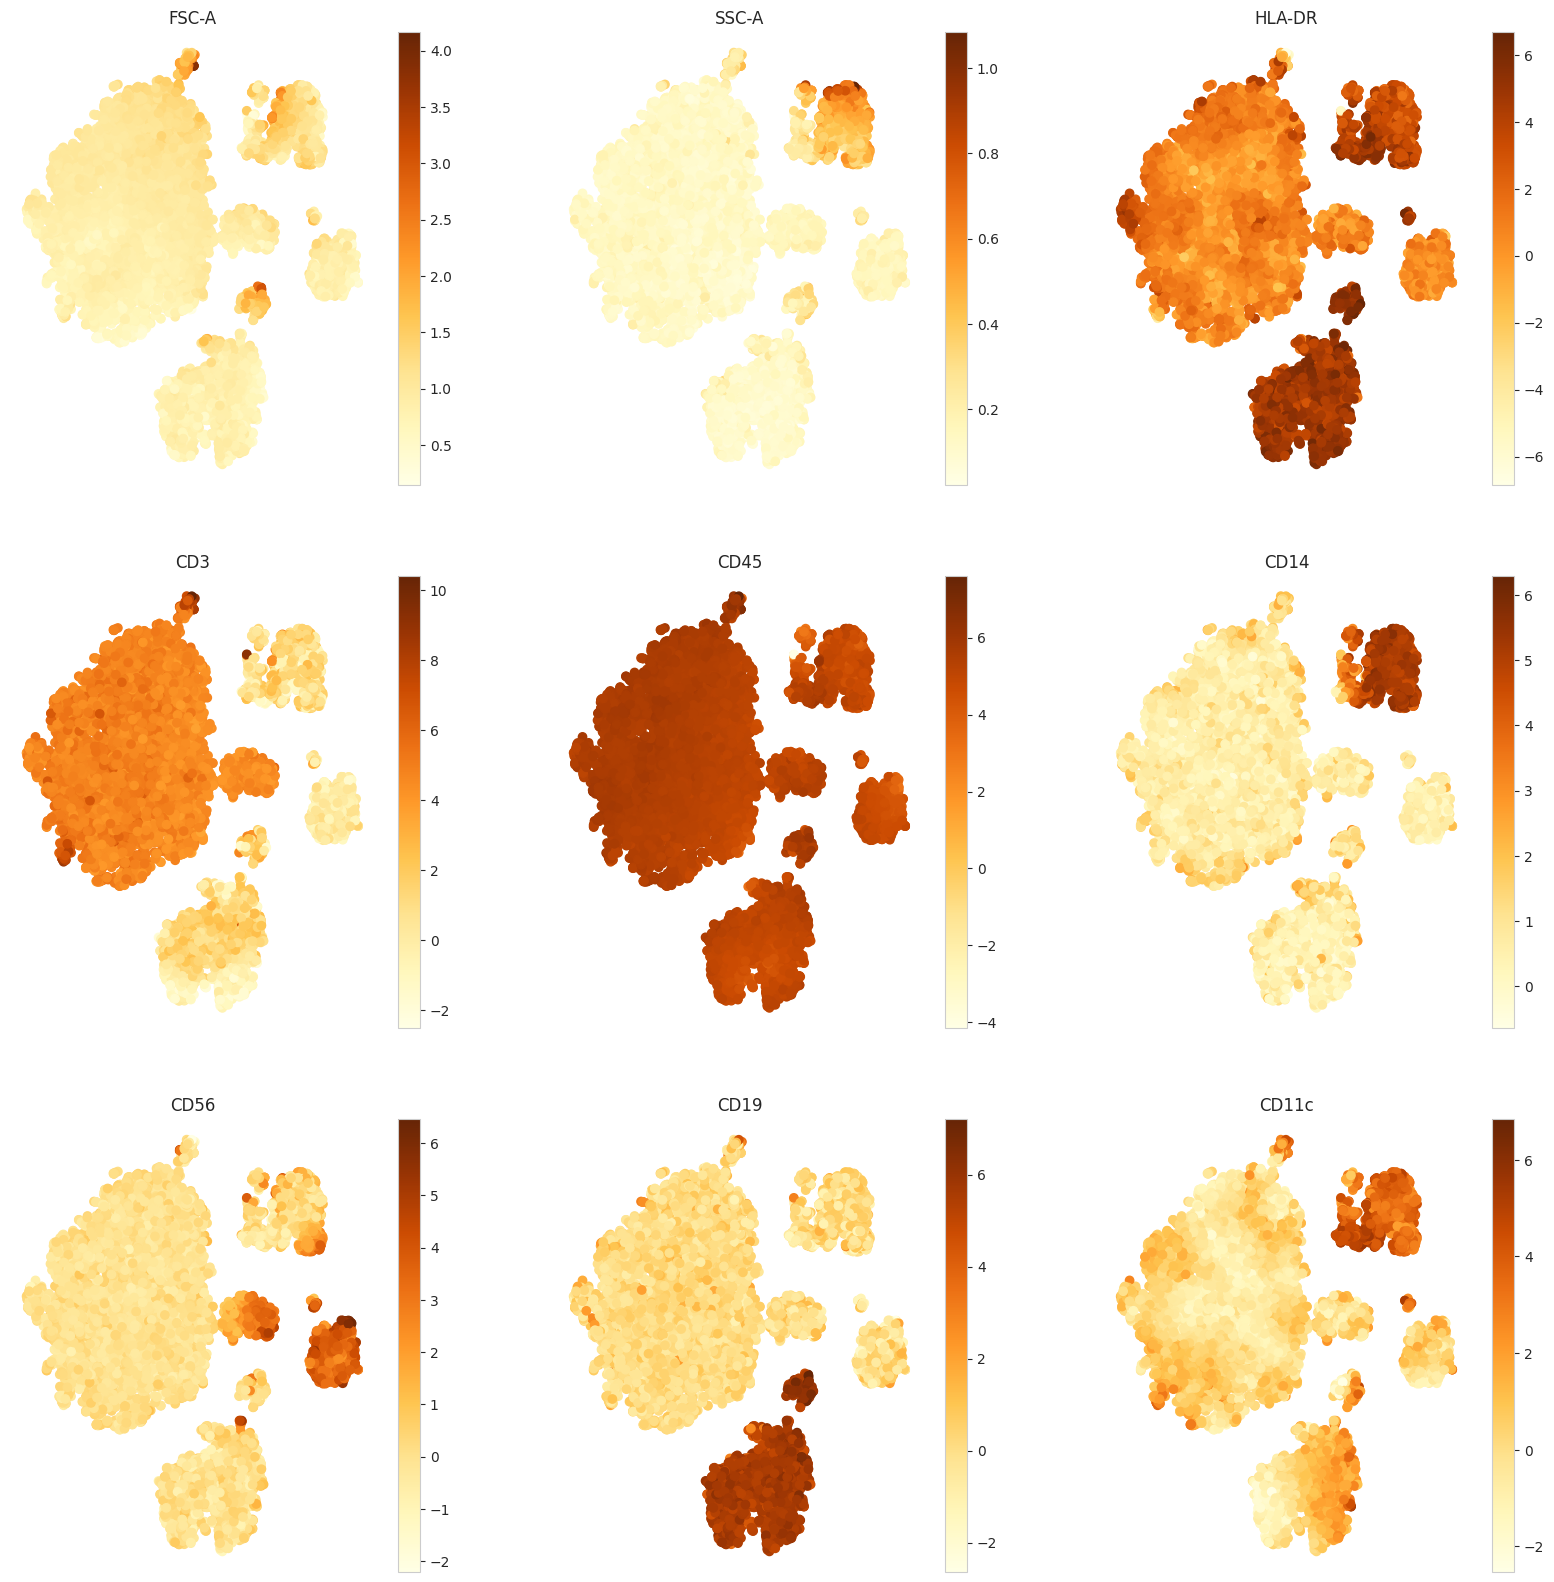

In [41]:
# Результаты t-SNE уже есть в переменной tsne_res НЕСТАНДАРТИЗИРОВАННЫЙ ВАР
fig, axes = plt.subplots(3, 3, figsize=(20, 20))
for col, ax in zip(fc_data.columns, axes.ravel()):
    scatter = ax.scatter(tsne_res[:, 0], tsne_res[:, 1], 
                         c=fc_data[col], cmap="YlOrBr")
    fig.colorbar(scatter, ax=ax)
    ax.set_title(col)
    ax.grid(False)
    ax.axis("off")

Дальше дело за вами, нужно определить клеточный тип для каждого кластера и записать их как значения в словаре:

>*CD3 T-cell, CD19 B-cell, CD14|CD11c Monocytes*

In [34]:
cell_type_cluster_map = {0: "T_cells", 
                         1: "B_cells", 
                         2: "Monocytes", 
                         3: "Other cells"}

In [42]:
labeled_fc_data = fc_data.assign(Population=clust.labels_)
labeled_fc_data["Population"] = labeled_fc_data["Population"].map(cell_type_cluster_map)

Посчитайте, как распределены типы клеток:

In [43]:
labeled_fc_data.Population.value_counts()

Population
T_cells        5915
B_cells        2028
Monocytes      1083
Other cells     968
Name: count, dtype: int64

>ну хотя бы не всё в одном, но в целом они несбалансированы конечно

Сохраните ваши результаты в csv файл, мы сравним их с правильными ответами по метрике `f1_score(average="macro")`, которая хорошо подходит, даже если классы не сбалансированы.

In [57]:
#наверно, нужно вернуть аутлаеры обратно в df
only_outl = orig_fc_data[((orig_fc_data['FSC-A'] > 10) | 
              (orig_fc_data['SSC-A'] > 10) |
              (orig_fc_data['CD56'] < -10) |
              (orig_fc_data['CD11c'] < -10) |
              (orig_fc_data['CD45'] < -5))]
only_outl['Population'] = 'Other cells' #надо им установить хоть что-нибудь, логично взять как другие клетки
data_to_csv = pd.concat([labeled_fc_data, only_outl]).sort_index()

data_to_csv.to_csv(join(DATA_PATH, 'labeled_fc_data.csv'))

#### 3.4. Атоматическая аннотация

**дополнительные** 5 баллов

Это задание является дополнительным. Вам нужно построить классификатор клеточных типов на основе размеченных вами данных. Пока что мы прошли не так много разных классификаторов, но уже есть из чего выбирать.

Оцените качество полученной модели при помощи `f1_score(average="macro")`. Попробуйте его улучшить, каким-то образом поработав с дисбалансом классов ([помощь](https://elitedatascience.com/imbalanced-classes)).

In [58]:
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

In [59]:
#берём данные
X = labeled_fc_data.drop('Population', axis=1)
y = labeled_fc_data[['Population']]

#они уже стандартизованы, поэтому сразу к сплиту
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=SEED, stratify=y)

In [60]:
from sklearn.neighbors import KNeighborsClassifier
#knn
neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(X_train, y_train)
y_pred = neigh.predict(X_test)
f1_score(y_test, y_pred, average='macro')

0.9887719987470487

In [61]:
from sklearn.linear_model import LogisticRegression
#логистическая регрессия
clf = LogisticRegression(random_state=SEED)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
f1_score(y_test, y_pred, average='macro')

0.9934926625986789

>они оба неплохо тут сработали согласно f1-скору

### Задание 4. Любимое место

дополнительно 0.5 балла

Расскажите о вашем любимом месте, куда бы вы хотели съездить этой весной, если вы уже там бывали, то прикрепите фотографию)

>Сначала подумала, что название "Любимое место" означает любимое место домашки, когда всё закончил))
>
>Сейчас прям любимых мест даже, наверное, и нет. Буду в Питре погуляю по городу, загляну к мостам. Всё слишком стандартно, скину вам ночную Лахту

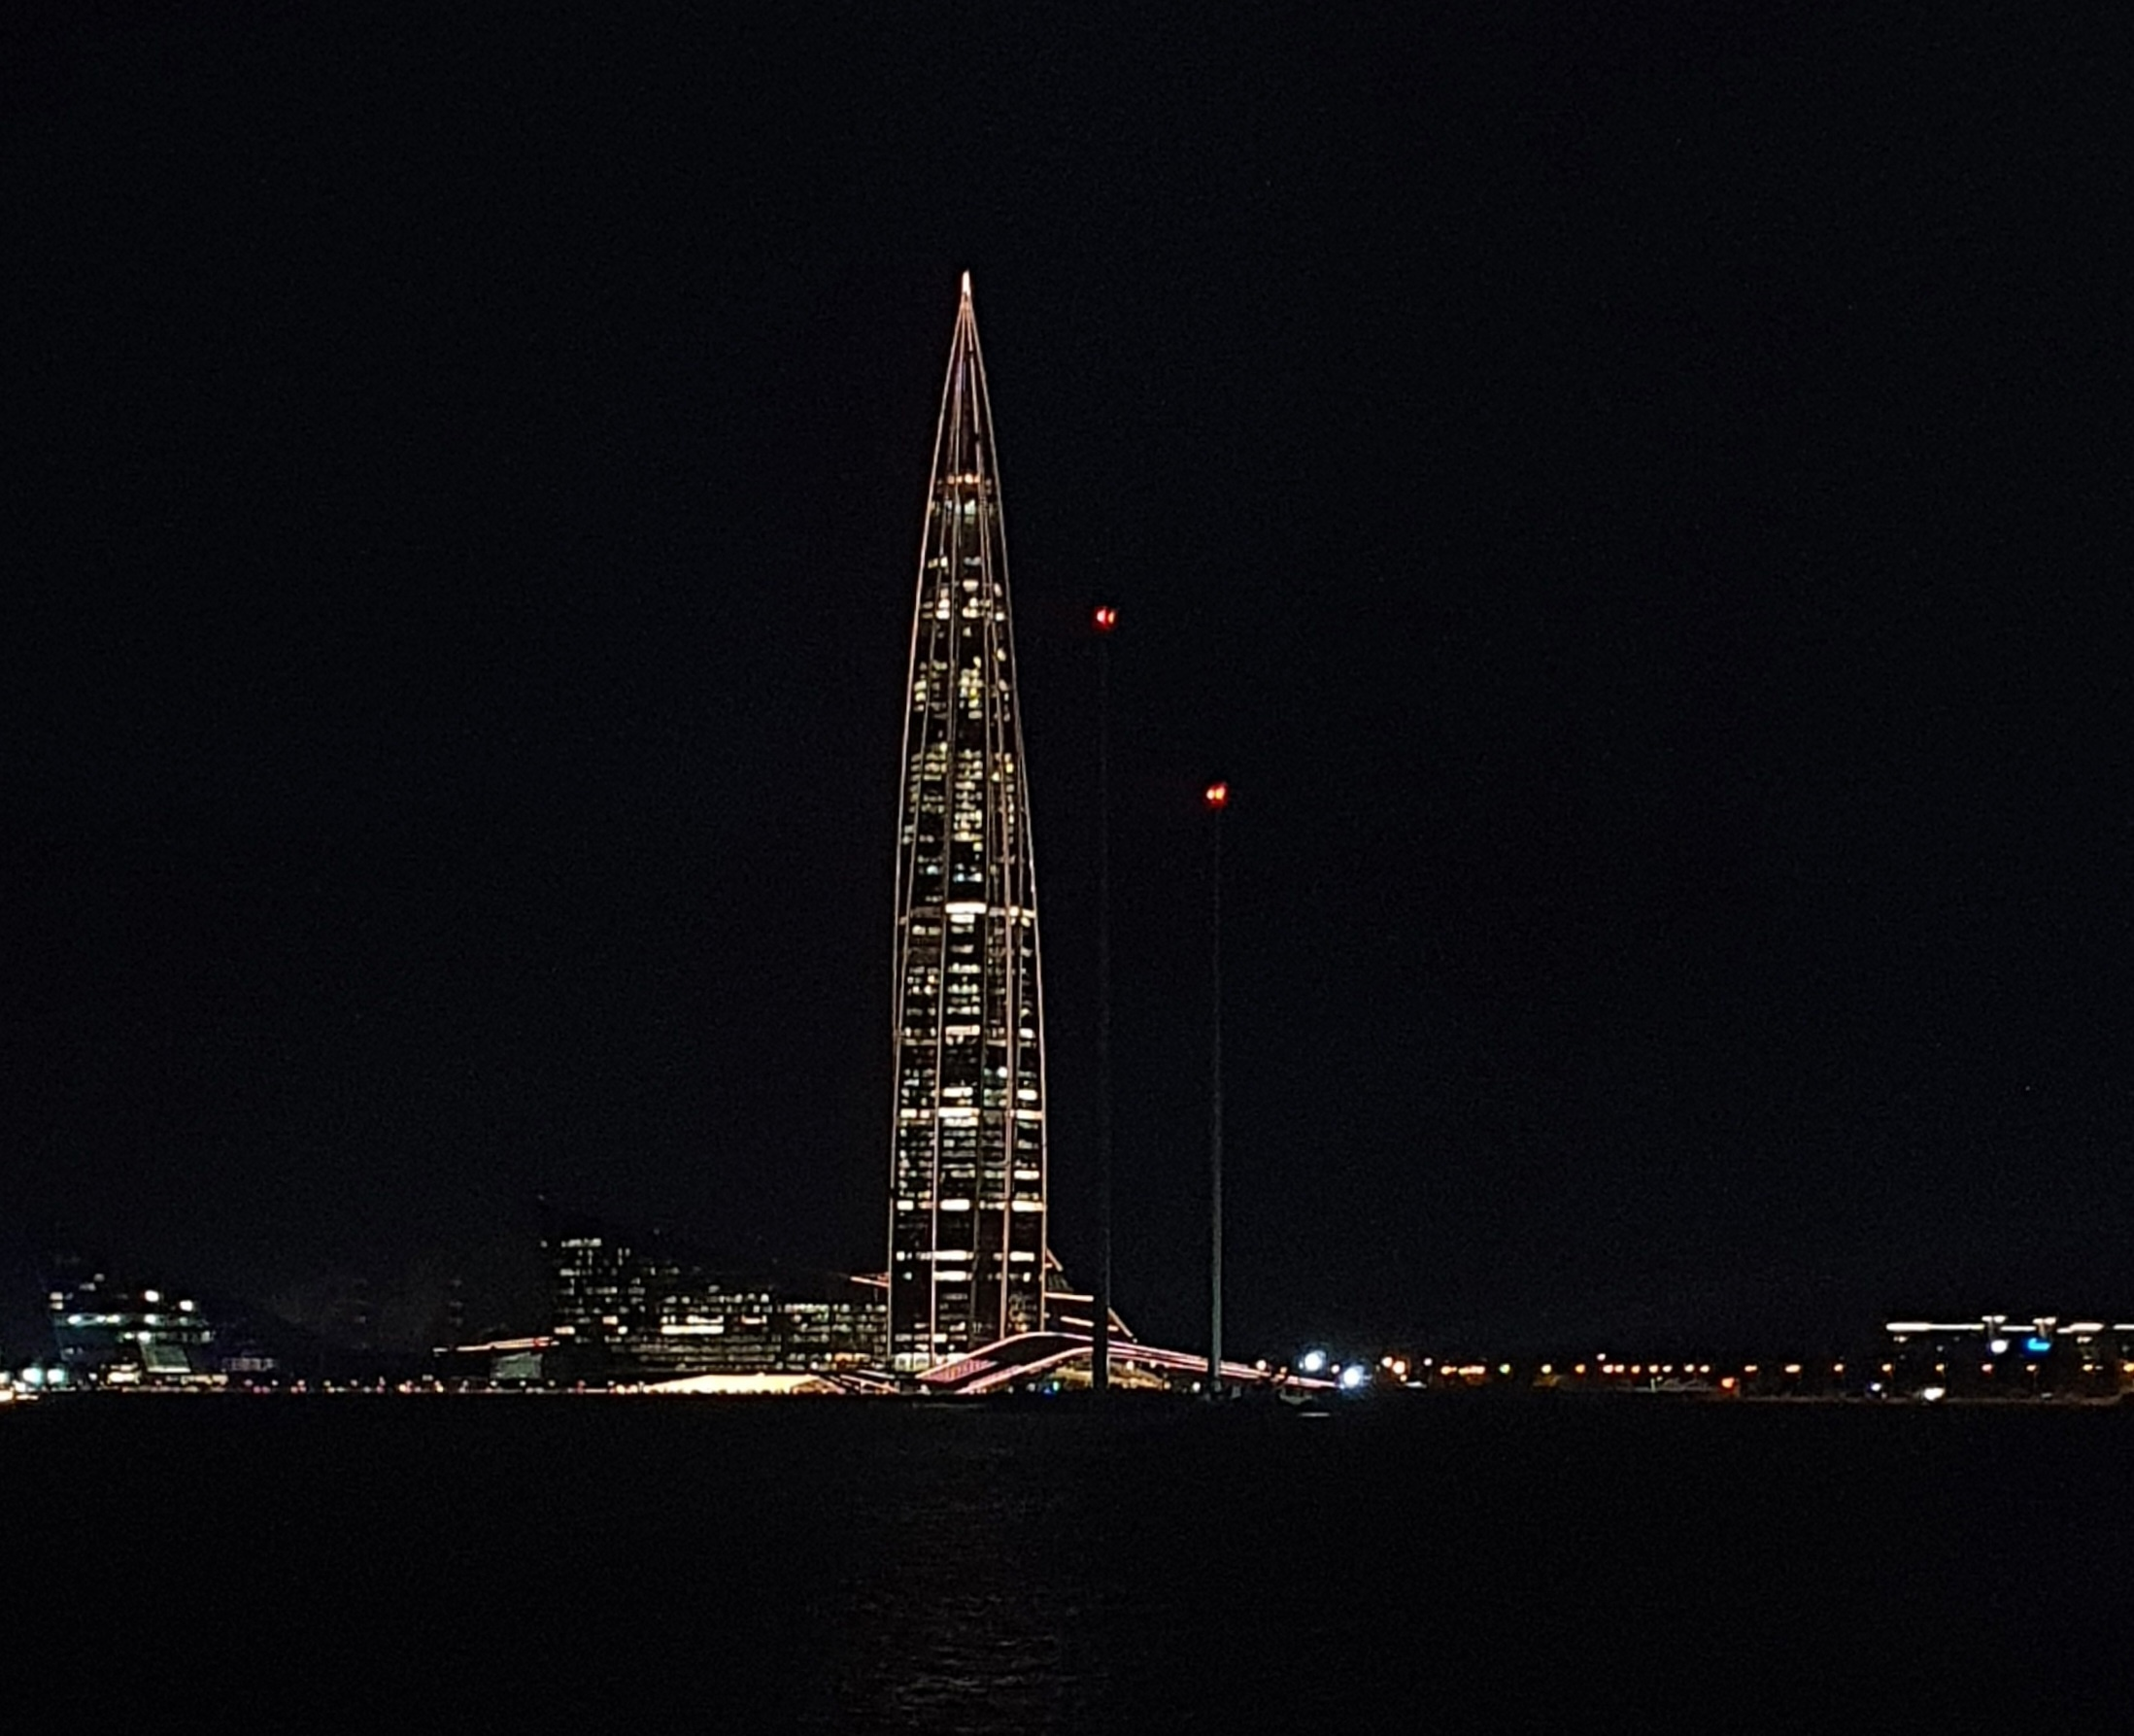

### Therapy time

Напишите здесь ваши впечатления о задании: было ли интересно, было ли слишком легко или наоборот сложно и тд. Также сюда можно написать свои идеи по улучшению заданий, а также предложить данные, на основе которых вы бы хотели построить следующие дз.

**Ваши мысли:**

круто, что был примерчик с биологией)